# Table of contents:
1. [Import packages](#import_packages)
2. [Gather Data](#Gather_data)
    1. [Twitter Archive](#archive_data)
    2. [Image prediction](#image_data)
    3. [Twitter API Data](#api_data)
3. [Assessing Data](#data_assess)
    1. [Quality](#quality)
    2. [Tideness](#tidy)
4. [Clean Data](#clean_all)
    1. [Tideness: Combine dog stages columns ](#tidy_1)
    2. [Cleanness: Records has *False* predictions for all algorithms](#clean_1)
    3. [Tideness: Predictions spread across several columns](#tidy_2)
    4. [Cleanness: Rows with *False* predictions not needed](#clean_2)
    5. [Cleanness: Rows with more than one *True* predictions from diffrent algorithms](#clean_3)
    6. [Cleanness: Source is represented as URL not name](#clean_4)
    7. [Cleanness: All datasets contains replies and re-tweets](#clean_5)
    8. [Cleanness: Drop columns related to retweets and external URL](#clean_6)
    9. [Cleanness: Invalid values for rating_numerator and rating_denominator](#clean_10)
    10. [Cleanness: Convert tweet_id to string in all files](#clean_7)
    11. [Cleanness: Convert timpestamp to month and day interval](#clean_10) 
    12. [Cleanness: Image and API data contains tweet_id not in archive data](#clean_8)
    13. [Cleanness: Missing dog name in archive data](#clean_9)
    14. [Tideness: Data spread across three sheets](#tidy_3)
5. [Visualization](#visual)

# Import packages  
<a id = "import_packages"></a>

In [1247]:
# import packages  
import pandas as pd
import numpy as np
import os
import json
import requests
import matplotlib.pyplot as plt
% matplotlib inline
from bs4 import BeautifulSoup
import seaborn as sns
sns.set_style('darkgrid')
import re






### Gather Data
<a id = "Gather_data"></a>

 Data gathered from 3 sources:
 
- Twitter archive data from downloadable file "twitter-archive-enhanced.csv"
- Image prediction data from online source [URL](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)
- Twitter API data for re-tweets counts 

 
 

#### Twitter Archive 
<a id = "archive_data"></a>

File "twitter-archive-enhanced.csv" was downloaded and uploaded to Jupter notebook

In [1248]:
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")

#### Image prediction
<a id = "image_data"></a>

In [1249]:
#scrap image date from URL
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split("/")[-1] 
response = response =requests.get(url)
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)

image_prediction = pd.read_csv("image-predictions.tsv", sep='\t') 

#### Twitter API Data
<a id = "api_data"></a>

Unfortunately due to time limitation, I was not able to generate the token in due time , I will apply this method separately after submitting. File "tweet-json.txt" was downloaded and uploaded to Jupter notebook

In [1250]:
df_list = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        source = tweet['source']
        in_reply_to_status_id = tweet['in_reply_to_status_id']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count,
                       #'source':source,
                       'in_reply_to_status_id': in_reply_to_status_id})
        
twitter_api = pd.DataFrame(df_list)

# Source_dict ={'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':"Twitter for iPhone",
# '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':"Twitter Web Client",
# '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':"Vine - Make a Scene",
# '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':"TweetDeck"}

# for source in api_df_now.source:
#     if source in Source_dict.keys():
#         api_df_now.apply( api_df_now.source== Source_dict[source])




## Assessing Data
<a id = "data_assess"></a>





In [1251]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [1252]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [1253]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [1254]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
favorite_count           2331 non-null int64
in_reply_to_status_id    77 non-null float64
retweet_count            2331 non-null int64
tweet_id                 2331 non-null int64
user_count               2331 non-null int64
dtypes: float64(1), int64(4)
memory usage: 91.1 KB


In [1255]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [1256]:
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [1257]:
twitter_api.describe()

,favorite_count,in_reply_to_status_id,retweet_count,tweet_id,user_count
count,2331.000000,7.700000e+01,2331.000000,2.331000e+03,2.331000e+03
mean,7408.206778,7.440692e+17,2633.511369,7.419079e+17,8.877584e+06
std,11507.318435,7.524295e+16,4454.002099,6.823170e+16,7.394345e+01
min,0.000000,6.658147e+17,1.000000,6.660209e+17,8.877566e+06
25%,1286.500000,6.757073e+17,534.500000,6.782670e+17,8.877567e+06
50%,3218.000000,7.032559e+17,1231.000000,7.182469e+17,8.877579e+06
75%,9065.000000,8.233264e+17,3056.000000,7.986692e+17,8.877580e+06
max,152869.000000,8.862664e+17,75668.000000,8.924206e+17,8.878225e+06


In [1258]:
twitter_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [1259]:
twitter_archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [1260]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_numerator>10 and rating_denominator<10 ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None


In [1261]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_numerator<10 and rating_denominator>10 ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1662,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,None,None,None,None


In [1262]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_numerator>100 and rating_denominator>100 ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None
1779,677716515794329600,NaN,NaN,2015-12-18 05:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515...,144,120,None,None,None,None,None


In [1263]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_numerator>100 and rating_denominator<100')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None


In [1264]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_numerator<100 and rating_denominator>100')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [1265]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_denominator<10 ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


In [1266]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_denominator>10 ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None


In [1267]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_numerator<6 ')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Not familiar with this breed. N...,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,None,None,None
730,781661882474196992,NaN,NaN,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Who keeps sending in pictures without dogs in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781661882...,5,10,None,None,None,None,None
765,777885040357281792,NaN,NaN,2016-09-19 15:00:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wesley. He's clearly trespassing. Seem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/777885040...,3,10,Wesley,None,None,None,None
883,760252756032651264,NaN,NaN,2016-08-01 23:15:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Fido. He can tell the weather. Not goo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760252756...,4,10,Fido,None,None,None,None
912,757596066325864448,NaN,NaN,2016-07-25 15:19:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's another picture without a dog in it. Id...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/757596066...,4,10,None,None,None,None,None
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847...,5,10,None,doggo,None,pupper,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None


In [1268]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [1269]:
pd.DatetimeIndex(twitter_archive['timestamp']).month_name().unique()

Index(['August', 'July', 'June', 'May', 'April', 'March', 'February',
       'January', 'December', 'November', 'October', 'September'],
      dtype='object', name='timestamp')

In [1270]:
pd.DatetimeIndex(twitter_archive['timestamp']).year.unique()

Int64Index([2017, 2016, 2015], dtype='int64', name='timestamp')

In [1271]:
pd.DatetimeIndex(twitter_archive['timestamp']).hour.unique()

Int64Index([16, 0, 15, 1, 17, 3, 23, 20, 2, 22, 21, 19, 12, 18, 13, 14, 4, 6,
            5],
           dtype='int64', name='timestamp')

In [1272]:
twitter_archive.groupby(pd.DatetimeIndex(twitter_archive['timestamp']).hour).count()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
timestamp,,,,,,,,,,,,,,,,,
0,291,10,10,291,291,291,23,23,23,285,291,291,291,291,291,291,291
1,328,7,7,328,328,328,32,32,32,322,328,328,328,328,328,328,328
2,255,3,3,255,255,255,29,29,29,251,255,255,255,255,255,255,255
3,199,8,8,199,199,199,12,12,12,197,199,199,199,199,199,199,199
4,112,8,8,112,112,112,5,5,5,105,112,112,112,112,112,112,112
5,30,2,2,30,30,30,1,1,1,28,30,30,30,30,30,30,30
6,5,1,1,5,5,5,0,0,0,4,5,5,5,5,5,5,5
12,2,2,2,2,2,2,0,0,0,0,2,2,2,2,2,2,2
13,5,1,1,5,5,5,2,2,2,4,5,5,5,5,5,5,5


In [1273]:
twitter_archive.query('rating_numerator==1776')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [1274]:
twitter_archive.query('tweet_id ==886983233522544640')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
26,886983233522544640,NaN,NaN,2017-07-17 16:17:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maya. She's very shy. Rarely leaves he...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886983233...,13,10,Maya,None,None,None,None


In [1275]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [1276]:
twitter_archive.notnull().sum()

tweet_id                      2356
in_reply_to_status_id           78
in_reply_to_user_id             78
timestamp                     2356
source                        2356
text                          2356
retweeted_status_id            181
retweeted_status_user_id       181
retweeted_status_timestamp     181
expanded_urls                 2297
rating_numerator              2356
rating_denominator            2356
name                          2356
doggo                         2356
floofer                       2356
pupper                        2356
puppo                         2356
dtype: int64

In [1277]:
twitter_api.tweet_id.notnull().sum()

2331

In [1278]:
image_prediction.tweet_id.notnull().sum()

2075

In [1279]:
image_prediction.query('p1_dog==False and p2_dog==False and p3_dog==False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,5.514170e-05,False,acorn,2.625800e-05,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,1.140710e-01,False,common_iguana,4.325530e-02,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,1.901420e-01,False,wig,3.450970e-02,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,1.260080e-02,False,coyote,5.735010e-05,False


In [1280]:
twitter_archive.query('doggo=="doggo" and floofer =="floofer" and pupper == "pupper" and puppo=="puppo"')


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [1281]:
twitter_archive.query('doggo=="None" and floofer =="None" and pupper == "None" and puppo=="None" and name =="None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None
42,884247878851493888,NaN,NaN,2017-07-10 03:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,NaN,NaN,https://twitter.com/kaijohnson_19/status/88396...,13,10,None,None,None,None,None


In [1282]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [1283]:
twitter_archive.duplicated().sum()

0

In [1284]:
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Oliver         11
Lucy           11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
the             8
Sadie           8
Bailey          7
Toby            7
Daisy           7
Buddy           7
an              7
Oscar           6
Leo             6
Jack            6
Milo            6
Koda            6
Scout           6
Bella           6
Stanley         6
Dave            6
Jax             6
Rusty           6
Sammy           5
             ... 
Ferg            1
Farfle          1
Juckson         1
Jennifur        1
Dallas          1
incredibly      1
Trigger         1
Griswold        1
Timmy           1
Biden           1
Dug             1
Winifred        1
Zara            1
Karl            1
Josep           1
Mac             1
Jo              1
Alexander       1
Mitch           1
Gilbert         1
Jeb             1
Dwight          1
Joey            1
Tassy           1
Shelby    

In [1285]:
twitter_archive.query('name == "None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


In [1286]:
twitter_archive[twitter_archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [1287]:
twitter_archive.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [1288]:
image_prediction.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [1289]:
twitter_api.head(20)

,favorite_count,in_reply_to_status_id,retweet_count,tweet_id,user_count
0,35459,NaN,7486,892420643555336193,8877566
1,30691,NaN,5557,892177421306343426,8877566
2,23081,NaN,3680,891815181378084864,8877566
3,38742,NaN,7664,891689557279858688,8877566
4,37025,NaN,8267,891327558926688256,8877566
5,18661,NaN,2767,891087950875897856,8877566
6,10844,NaN,1797,890971913173991426,8877566
7,59758,NaN,16768,890729181411237888,8877566
8,25682,NaN,3822,890609185150312448,8877566
9,29315,NaN,6508,890240255349198849,8877566


In [1290]:
test = twitter_archive[twitter_archive.retweeted_status_id.notnull()]+ twitter_archive[twitter_archive.in_reply_to_status_id.notnull()] + twitter_archive[twitter_archive.in_reply_to_user_id.notnull()] + twitter_archive[twitter_archive.retweeted_status_user_id.notnull()]
test.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1291]:
twitter_archive[twitter_archive.in_reply_to_user_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [1292]:
twitter_archive[twitter_archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [1293]:
##checking one record by name to make sure original tweet exist
twitter_archive.query('name =="Canela"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None


In [1294]:
twitter_api[twitter_api.in_reply_to_status_id.notnull()]

,favorite_count,in_reply_to_status_id,retweet_count,tweet_id,user_count
29,110,8.862664e+17,4,886267009285017600,8877566
54,116,8.816070e+17,7,881633300179243008,8877566
63,292,8.795538e+17,10,879674319642796034,8877566
109,113,8.707262e+17,3,870726314365509632,8877566
142,2062,8.634256e+17,88,863427515083354112,8877566
143,8230,6.671522e+17,1019,863079547188785154,8877566
172,214,8.571567e+17,17,857214891891077121,8877567
176,11295,8.558181e+17,1762,856526610513747968,8877567
180,318,8.558616e+17,23,855862651834028034,8877567
181,4663,8.558585e+17,917,855860136149123072,8877567


### Quality:
<a id = "quality"></a>

##### twitter_archive:
- tweet_id datatype can be string as no statistical operations to be done on it 
- not all tweets have image attached 
- 745 records with "None" as dog name 
- incorrect dog names 
- 181 records are re_tweets
- 78 records are replies  
- 1976 wih None value for all dog type columns (doggo, floofer, pupper, puppo) 
- source is represented as URL not name -- Done
- retweeted_status_user_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id will not be used as we are not cocerned with re-tweets, to be dropped after removing retweets and replies from dataset 
- expanded_urls has no additional value as it respresent same tweet_id
- Some tweets are of people:
    - tweet_id "670842764863651840" has a person photo
    - tweet_id "673715861853720576" is Donald Trump
    - tweet_id "673700254269775872, 671544874165002241" person in doll suit
- tweet_id "810984652412424192" has no valid rating , text "Meet Sam. She smiles 24/7 & secretly aspires to be a reindeer. Keep Sam smiling by clicking and sharing this link:"
- tweet_id "740373189193256964" has rating 9/11 but it this refers to date, the rating should be 14/10
- tweet_id "722974582966214656" has rating 4/20 but it this refers to date, the rating should be 13/10 
- tweet_id "682962037429899265" has rating 7/11 but it this refers to date, the rating should be 10/10
- tweet_id "666287406224695296" should have 9/10 rating 
- tweet_id "716439118184652801" should have 11/10
- tweet_id "883482846933004288" should have 13.5/10
- tweet_id "674646392044941312" should have rating 8/10
- Some tweets are of other animals:
    - tweet_ids 777885040357281792, 707420581654872064,684959798585110529 , 680940246314430465 , 680798457301471234, 671744970634719232 ,668994913074286592, 667176164155375616, 666430724426358785  of goats
    - tweet_id "693590843962331137 , 677565715327688705 , 673906403526995968 , 669661792646373376" of cat
    - tweet_id "687102708889812993  , 674045139690631169 , 671122204919246848, 667443425659232256" of ducks
    (N.B. : i have decieded to leave these tweets as the admin rated them and consided them as part of humour )
- some tweets are with very low rates (zero ,2 ..) although they are dogs due to bad pics (e.g: https://twitter.com/dog_rates/status/667878741721415682) but will also leave them
    
- timestamp data can be split to represent the month, year and day interval:
    - (5:00 to 8:00) Early morning
    - (8:00 to 10:00) Late morning
    - (12:00 to 14:00) Early afternoon
    - (14:00 to 17:00) Late afternoon
    - (17:00 to 21:00) Early evening
    - (21:00 to 24:00) Late Evening
    - (00:00 to 5:00) Night


##### twitter_api:
- tweet_id datatype can be string as no statistical operations to be done on it 
- 78 records are replies 
- tweet_id in api data not available in the archive data 

##### image_predecition:
- 324 records has *False* predictions for all algorithms
- 1243 records has *True* predictions for all algorithms
- tweet_id datatype can be string as no statistical operations to be done on it    
- 3871 records with null tweet_id 
- tweet_id in image data not available in the archive data 
- Columns names in image_predictions are not meaningful and predictions can be grouped in fewer columns

### Tideness:
<a id = "tidy"></a>
- Dog type distributed among 4 columns (doggo, floofer, pupper, puppo)
- Information about one type of observational unit (tweets) is spread across three different files/dataframes. So these three dataframes should be merged as they are part of the same observational unit.

## Clean Data
<a id = "clean_all"></a>

In [1295]:
## copy frames: 
archive_data=twitter_archive.copy()
image_data =image_prediction.copy()
api_data = twitter_api.copy()

### Tideness
<a id = "tidy_1"></a>
Four columns to describe dog type (pupper, doggo, puppo, floofer)

##### Define

Combine dog type columns (pupper, doggo, puppo, floofer)into one column
Drop column *expanded_urls* 

##### Code

In [1296]:
#Merge dog_type columns into one 
archive_data['dog_type']=archive_data.floofer.str.cat(archive_data[['pupper', 'doggo','puppo']], sep=' - ')
archive_data.dog_type.unique()

array(['None - None - None - None', 'None - None - doggo - None',
       'None - None - None - puppo', 'None - pupper - None - None',
       'floofer - None - None - None', 'None - None - doggo - puppo',
       'floofer - None - doggo - None', 'None - pupper - doggo - None'], dtype=object)

In [1297]:
## consildate values for dog_types
for index, row in archive_data.iterrows():  
        if row['dog_type'] == "None - None - doggo - None":
            archive_data.loc[index,'dog_type'] = archive_data.loc[index,'dog_type']= 'doggo'
        elif row['dog_type'] == "None - None - None - puppo":
            archive_data.loc[index,'dog_type'] = archive_data.loc[index,'dog_type']='puppo'
        elif row['dog_type'] == "None - pupper - None - None":
            archive_data.loc[index,'dog_type'] = archive_data.loc[index,'dog_type']='pupper'
        elif row['dog_type'] == "floofer - None - None - None":
            archive_data.loc[index,'dog_type'] = archive_data.loc[index,'dog_type']='floofer'
        elif row['dog_type'] == "None - None - doggo - puppo":
            archive_data.loc[index,'dog_type'] = archive_data.loc[index,'dog_type']='doggo - puppo'
        elif row['dog_type'] == "floofer - None - doggo - None":
            archive_data.loc[index,'dog_type'] = archive_data.loc[index,'dog_type']='floofer - doggo'
        elif row['dog_type'] == "None - pupper - doggo - None":
            archive_data.loc[index,'dog_type'] = archive_data.loc[index,'dog_type']='pupper - doggo'
        else:
            archive_data.loc[index,'dog_type'] = np.nan

In [1298]:
# Drop columns 
archive_data = archive_data.drop(['doggo','floofer','puppo','pupper'], axis=1)

##### Test

In [1299]:
archive_data.dog_type.unique() 

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo - puppo',
       'floofer - doggo', 'pupper - doggo'], dtype=object)

In [1300]:
archive_data.dog_type.value_counts()

pupper             245
doggo               83
puppo               29
pupper - doggo      12
floofer              9
doggo - puppo        1
floofer - doggo      1
Name: dog_type, dtype: int64

In [1301]:
archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_type                      380 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 257.8+ KB


### Cleanness:
324 records has *False* predictions for all algorithms
<a id = "clean_1"></a>

#### Define
Drop rows with False value for all prediction as no way to get the right pedictions

#### Code

In [1302]:
image_prdict_all_false = image_data.query('p1_dog==False and p2_dog==False and p3_dog==False')
image_prdict_all_false.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 6 to 2074
Data columns (total 12 columns):
tweet_id    324 non-null int64
jpg_url     324 non-null object
img_num     324 non-null int64
p1          324 non-null object
p1_conf     324 non-null float64
p1_dog      324 non-null bool
p2          324 non-null object
p2_conf     324 non-null float64
p2_dog      324 non-null bool
p3          324 non-null object
p3_conf     324 non-null float64
p3_dog      324 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 26.3+ KB


In [1303]:
# image_prdict_all_true = image_data.query('p1_dog==True and p2_dog==True and p3_dog==True')


In [1304]:
image_data= image_data[~image_data.tweet_id.isin(image_prdict_all_false.tweet_id)]
# image_data= image_data[~image_data.tweet_id.isin(image_prdict_all_true.tweet_id)]

##### Test

In [1305]:
image_prdict_all_false.info(),image_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 6 to 2074
Data columns (total 12 columns):
tweet_id    324 non-null int64
jpg_url     324 non-null object
img_num     324 non-null int64
p1          324 non-null object
p1_conf     324 non-null float64
p1_dog      324 non-null bool
p2          324 non-null object
p2_conf     324 non-null float64
p2_dog      324 non-null bool
p3          324 non-null object
p3_conf     324 non-null float64
p3_dog      324 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 26.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf   

(None, None)

In [1306]:
image_data.query('p1_dog==False and p2_dog==False and p3_dog==False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Tideness
<a id = "tidy_2"></a>
Predictions spread across several columns 
##### Define
Combine predictions into one column

##### Code

In [1307]:
# Renaming the dataset columns
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_data.columns = cols

In [1308]:
# Reshaping the dataframe
image_data = pd.wide_to_long(image_data, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()


#### Test

In [1309]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5253 entries, 0 to 5252
Data columns (total 7 columns):
tweet_id            5253 non-null int64
jpg_url             5253 non-null object
img_num             5253 non-null int64
prediction_level    5253 non-null int64
prediction          5253 non-null object
confidence          5253 non-null float64
breed               5253 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 251.4+ KB


In [1310]:
image_data.head()

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True


In [1311]:
image_data.tweet_id.duplicated().sum() 

3502

In [1312]:
image_data.query('breed==False').prediction.unique()

array(['fur_coat', 'shopping_cart', 'shopping_basket', 'ox', 'llama',
       'dingo', 'chain_saw', 'power_drill', 'seat_belt', 'teddy', 'hay',
       'water_buffalo', 'ice_bear', 'weasel', 'Christmas_stocking',
       'ski_mask', 'hare', 'dhole', 'web_site', 'toyshop', 'bath_towel',
       'muzzle', 'leatherback_turtle', 'terrapin', 'hog', 'cowboy_boot',
       'giant_panda', 'minivan', 'canoe', 'paddle', 'king_penguin',
       'Arctic_fox', 'titi', 'Angora', 'ram', 'vacuum', 'toilet_tissue',
       'black-footed_ferret', 'pillow', 'shower_curtain', 'bathtub',
       'doormat', 'waffle_iron', 'seashore', 'sandbar', 'white_wolf',
       'hamster', 'piggy_bank', 'hair_spray', 'guinea_pig', 'corn',
       'bolete', 'window_shade', 'window_screen', "jack-o'-lantern",
       'sorrel', 'indri', 'home_theater', 'television',
       'American_black_bear', 'brown_bear', 'menu', 'bathing_cap',
       'Persian_cat', 'goose', 'hen', 'wood_rabbit', 'African_hunting_dog',
       'plow', 'red_wolf', 

### Cleanness:
Rows with *False* predictions not needed
##### Define 
 Remove rows with false predictions 
<a id = "clean_2"></a>

##### Code 

In [1313]:
image_data= image_data[~image_data.breed == False]

In [1314]:
## set all values to lower case 
image_data.prediction = image_data.prediction.str.lower()

##### Test 

In [1315]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4584 entries, 0 to 5252
Data columns (total 7 columns):
tweet_id            4584 non-null int64
jpg_url             4584 non-null object
img_num             4584 non-null int64
prediction_level    4584 non-null int64
prediction          4584 non-null object
confidence          4584 non-null float64
breed               4584 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 255.2+ KB


In [1316]:
image_data.prediction.unique()

array(['welsh_springer_spaniel', 'collie', 'shetland_sheepdog', 'redbone',
       'miniature_pinscher', 'rhodesian_ridgeback', 'german_shepherd',
       'malinois', 'bloodhound', 'rottweiler', 'doberman',
       'bernese_mountain_dog', 'english_springer',
       'greater_swiss_mountain_dog', 'chow', 'tibetan_mastiff',
       'golden_retriever', 'miniature_poodle', 'komondor',
       'soft-coated_wheaten_terrier', 'labrador_retriever',
       'gordon_setter', 'yorkshire_terrier', 'pekinese', 'walker_hound',
       'english_foxhound', 'ibizan_hound', 'pug', 'bull_mastiff',
       'french_bulldog', 'lhasa', 'shih-tzu', 'dandie_dinmont',
       'english_setter', 'newfoundland', 'borzoi', 'italian_greyhound',
       'toy_terrier', 'basenji', 'maltese_dog', 'toy_poodle',
       'groenendael', 'chesapeake_bay_retriever', 'malamute',
       'siberian_husky', 'eskimo_dog', 'afghan_hound', 'briard',
       'chihuahua', 'papillon', 'black-and-tan_coonhound',
       'flat-coated_retriever', 'blenh

### Cleanness:
Rows with more than one *True* predictions through diffrent algothihims 
##### Define 
 Remove rows with false predictions 
<a id = "clean_3"></a>

##### Code

In [1317]:
# x = image_data[image_data.breed == True]
# y =x.sort_values('confidence').reset_index()
# z = y.drop_duplicates('tweet_id', keep='last')
# g=x.groupby('tweet_id')['prediction','confidence'].max()

image_data =image_data[image_data.breed == True].sort_values('confidence').reset_index(drop=True).drop_duplicates('tweet_id', keep='last')

In [1318]:
image_data.reset_index(drop=True,inplace=True)

##### Test

In [1319]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 7 columns):
tweet_id            1751 non-null int64
jpg_url             1751 non-null object
img_num             1751 non-null int64
prediction_level    1751 non-null int64
prediction          1751 non-null object
confidence          1751 non-null float64
breed               1751 non-null bool
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 83.9+ KB


In [1320]:
image_data.tweet_id.duplicated().sum()

0

### Cleanness:
Source is represented as URL not name
##### Define 
Change the source value from URL to value using BeautifulSoup
<a id = "clean_4"></a>

#### Code

In [1321]:
def source_update (archive_data):
    for source in  archive_data['source']:
#         print(archive_data['source'])
#         print (source)
        soup = BeautifulSoup(archive_data['source'], 'html.parser')
#         print(soup)
        source =soup.a.contents
#         print(soup)
#         print(source[0])
        return source[0]
    

archive_data['source'] = archive_data.apply(source_update, axis=1)         

#### Test

In [1322]:
archive_data.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

In [1323]:
archive_data.info()             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_type                      380 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 257.8+ KB


### Cleanness:
All datasets contains replies and re-tweets 
##### Define 
Remove the records for replies and re-tweets
<a id = "clean_5"></a>


#### Code

In [1324]:
archive_data = archive_data[~ archive_data.in_reply_to_user_id.notnull()]
archive_data = archive_data[~ archive_data.retweeted_status_id.notnull()]
api_data = api_data[~ api_data.in_reply_to_status_id.notnull()]

#### Test

In [1325]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2254 entries, 0 to 2330
Data columns (total 5 columns):
favorite_count           2254 non-null int64
in_reply_to_status_id    0 non-null float64
retweet_count            2254 non-null int64
tweet_id                 2254 non-null int64
user_count               2254 non-null int64
dtypes: float64(1), int64(4)
memory usage: 105.7 KB


In [1326]:
archive_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
dog_type                      336 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 245.7+ KB


### Cleanness:
Columns to with no added values after removing retweets 
##### Define 
Remove in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id from archive dataset
<a id = "clean_6"></a>


#### Code

In [1327]:
archive_data = archive_data.drop('retweeted_status_user_id',axis =1)
archive_data = archive_data.drop('in_reply_to_status_id' ,axis =1)
archive_data = archive_data.drop('in_reply_to_user_id' ,axis =1)
archive_data = archive_data.drop('retweeted_status_id' ,axis =1)
archive_data = archive_data.drop('retweeted_status_timestamp' ,axis =1)
# archive_data = archive_data.drop('expanded_urls', axis=1) 



#### Test

In [1328]:
archive_data.info()
# archive_data.query('name=="Roscoe"')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
dog_type              336 non-null object
dtypes: int64(3), object(6)
memory usage: 163.8+ KB


### Cleanness:
Invalid values for rating_numerator and rating_denominator
##### Define 
change data type of columns to float and update the values for defined issues
- tweet_id "740373189193256964" has rating 9/11 but it this refers to date, the rating should be 14/10
- tweet_id "722974582966214656" has rating 4/20 but it this refers to date, the rating should be 13/10 
- tweet_id "682962037429899265" has rating 7/11 but it this refers to date, the rating should be 10/10
- tweet_id "666287406224695296" should have 9/10 rating 
- tweet_id "716439118184652801" should have 11/10
- tweet_id "883482846933004288" should have 13.5/10
- tweet_id "674646392044941312" should have rating 8/10
- tweet_id "810984652412424192" no valid rating -- will set rating to zero 
- tweet_id "835152434251116546" bad pic with 0 rating  -- will keep as is
<a id = "clean_10"></a>

In [1329]:
archive_data.rating_numerator= archive_data.rating_numerator.astype(float)

In [1330]:
# archive_data.rating_denominator= archive_data.rating_denominator.astype(float)

In [1331]:
# archive_data.loc[archive_data.tweet_id == 810984652412424192, 'rating_numerator'] = 0

In [1332]:
archive_data[archive_data.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator','tweet_id']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,text,rating_numerator,tweet_id
45,This is Bella. She hopes her smile made you sm...,5.0,883482846933004288
695,"This is Logan, the Chow who lived. He solemnly...",75.0,786709082849828864
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0,778027034220126208
1712,Here we have uncovered an entire battalion of ...,26.0,680494726643068929


In [1333]:
def change_rating():
    for key, value in  new_rating.items():
        archive_data.loc[archive_data.tweet_id == key, 'rating_numerator'] = value[0]
        archive_data.loc[archive_data.tweet_id == key, 'rating_denominator'] = value[1]
        

## new rating dixtionary for invlid values including the wrongly extracted from query above
new_rating ={740373189193256964 : [14, 10] ,
             722974582966214656:[13,10] ,
             682962037429899265:[10,10],
            666287406224695296:[9,10],
             716439118184652801:[11,10],
             883482846933004288:[13.5,10],
             674646392044941312:[8,10],
             810984652412424192:[0,10],
            786709082849828864:[9.75,10],
            778027034220126208:[11.27,10],
            680494726643068929:[11.26,10]}

change_rating()

In [1334]:
## for multiple dogs in one pic causing high rates
for index, row in archive_data.iterrows():  
        if row['rating_denominator'] >10:
            x = row['rating_denominator']/10
            archive_data.loc[archive_data.tweet_id == row['tweet_id'], 'rating_numerator'] = row['rating_numerator']/x
            archive_data.loc[archive_data.tweet_id == row['tweet_id'], 'rating_denominator'] = row['rating_denominator']/x

#### Test

In [1335]:
archive_data.query('rating_denominator<10 ')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type


In [1336]:
archive_data.query('rating_denominator>10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type


In [1337]:
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()].query('rating_denominator>10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None


In [1338]:
archive_data.query('tweet_id ==786709082849828864')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
695,786709082849828864,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,NaN


In [1339]:
archive_data.query('tweet_id ==883482846933004288')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type
45,883482846933004288,2017-07-08 00:28:19 +0000,Twitter for iPhone,This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.5,10.0,Bella,NaN


### Cleanness:
Tweet_id will not be used as statistical feature so it should be string
##### Define 
Convert tweet_id to string in all files
<a id = "clean_7"></a>

#### Code

In [1340]:
api_data.tweet_id = api_data.tweet_id.astype(str)

In [1341]:
image_data.tweet_id = image_data.tweet_id.astype(str)

In [1342]:
archive_data.tweet_id = archive_data.tweet_id.astype(str)

#### Test

In [1343]:
archive_data.info(), image_data.info(), api_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  2097 non-null object
dog_type              336 non-null object
dtypes: float64(2), object(7)
memory usage: 163.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 7 columns):
tweet_id            1751 non-null object
jpg_url             1751 non-null object
img_num             1751 non-null int64
prediction_level    1751 non-null int64
prediction          1751 non-null object
confidence          1751 non-null float64
breed               1751 non-null bool
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage:

(None, None, None)

In [1344]:
image_data.head()

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed
0,752519690950500352,https://pbs.twimg.com/media/CnF8qVDWYAAh0g1.jpg,3,2,labrador_retriever,0.000010,True
1,745433870967832576,https://pbs.twimg.com/media/ClhQJUUWAAEVpBX.jpg,1,2,basset,0.000014,True
2,818536468981415936,https://pbs.twimg.com/media/C1wGkYoVQAAuC_O.jpg,1,2,welsh_springer_spaniel,0.000062,True
3,776088319444877312,https://pbs.twimg.com/media/CsU4NKkW8AUI5eG.jpg,3,2,pug,0.000077,True
4,667550904950915073,https://pbs.twimg.com/media/CUOb_gUUkAACXdS.jpg,1,2,vizsla,0.000081,True


### Cleanness:
Timestamp data can be split to provide detailed informations
##### Define 
Convert Timestamp to columns for date ,month, year and day interval
<a id = "clean_10"></a>

##### Code

In [1345]:
archive_data['timestamp']=pd.to_datetime(archive_data['timestamp'])

In [1346]:
archive_data['month']=pd.DatetimeIndex(archive_data['timestamp']).month_name()

In [1347]:
archive_data['year']=pd.DatetimeIndex(archive_data['timestamp']).year

In [1348]:
archive_data['day']=pd.DatetimeIndex(archive_data['timestamp']).day_name()

In [1349]:
archive_data['date']=pd.DatetimeIndex(archive_data['timestamp']).date

In [1350]:
archive_data['month_year'] = pd.to_datetime(archive_data['timestamp']).dt.to_period('M')

In [1351]:
archive_data['time']=archive_data['timestamp'].dt.time

In [1352]:
## Add day interval column data
for index, row in archive_data.iterrows():  
        if row['time'].hour in range(5, 8):
            archive_data.loc[index,'day_interval'] = "Early morning"
        elif row['time'].hour in range(8, 10):
            archive_data.loc[index,'day_interval'] = "Late morning"
        elif row['time'].hour in range(12, 14):
            archive_data.loc[index,'day_interval'] = "Eraly afternoon"
        elif row['time'].hour in range(14, 17):
            archive_data.loc[index,'day_interval'] = "Late afternoon"
        elif row['time'].hour in range(17, 21):
            archive_data.loc[index,'day_interval'] = "Early evening"
        elif row['time'].hour in range(21, 0):
            archive_data.loc[index,'day_interval'] = "late evening"
#         elif row['time'].hour in range(0, 5):
#             archive_data.loc[index,'day_interval'] = "Night"
        else:
            archive_data.loc[index,'day_interval'] = "Night"

#### Test

In [1353]:
archive_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  2097 non-null object
dog_type              336 non-null object
month                 2097 non-null object
year                  2097 non-null int64
day                   2097 non-null object
date                  2097 non-null object
month_year            2097 non-null object
time                  2097 non-null object
day_interval          2097 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(12)
memory usage: 358.5+ KB


In [1354]:
archive_data.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,month,year,day,date,month_year,time,day_interval
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,August,2017,Tuesday,2017-08-01,2017-08,16:23:56,Late afternoon
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,August,2017,Tuesday,2017-08-01,2017-08,00:17:27,Night
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,July,2017,Monday,2017-07-31,2017-07,00:18:03,Night
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,July,2017,Sunday,2017-07-30,2017-07,15:58:51,Late afternoon
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,July,2017,Saturday,2017-07-29,2017-07,16:00:24,Late afternoon


In [1355]:
archive_data.groupby('day_interval').count()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,month,year,day,date,month_year,time
day_interval,,,,,,,,,,,,,,,
Early evening,450,450,450,450,450,450,450,450,73,450,450,450,450,450,450
Early morning,31,31,31,31,31,31,31,31,2,31,31,31,31,31,31
Eraly afternoon,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2
Late afternoon,305,305,305,305,304,305,305,305,45,305,305,305,305,305,305
Night,1309,1309,1309,1309,1307,1309,1309,1309,216,1309,1309,1309,1309,1309,1309


### Cleanness:
Image and API data contains tweet_id not in archive data
##### Define 
Remove the records from image prediction and API data where the tweet_id not in the archive data
<a id = "clean_8"></a>

#### Code

In [1356]:
image_data=image_data[~np.logical_not(image_data.tweet_id.isin(list(archive_data.tweet_id)))]

In [1357]:
image_data.shape

(1666, 7)

In [1358]:
# applying same logic on api data
api_data=api_data[~np.logical_not(api_data.tweet_id.isin(list(archive_data.tweet_id)))]

In [1359]:
api_data.shape

(2090, 5)

In [1360]:
## remove column api_data in_reply_to_status_id from api data
api_data.drop('in_reply_to_status_id', axis=1,inplace =True)

#### Test

In [1361]:
api_data.shape, image_data.shape,archive_data.shape

((2090, 4), (1666, 7), (2097, 16))

In [1362]:
image_data[np.logical_not(image_data.tweet_id.isin(list(archive_data.tweet_id)))]

,tweet_id,jpg_url,img_num,prediction_level,prediction,confidence,breed


In [1363]:
api_data[np.logical_not(api_data.tweet_id.isin(list(archive_data.tweet_id)))]

,favorite_count,retweet_count,tweet_id,user_count


In [1364]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2330
Data columns (total 4 columns):
favorite_count    2090 non-null int64
retweet_count     2090 non-null int64
tweet_id          2090 non-null object
user_count        2090 non-null int64
dtypes: int64(3), object(1)
memory usage: 81.6+ KB


### Cleanness:
Missing dog name in archive data
##### Define 
Extraxt dog name from text, usually found after words "name" or "named" 
<a id = "clean_9"></a>


#### Code

In [1365]:
pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
for index, row in archive_data.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern, row['text'])[0]
            archive_data.loc[index,'name'] = archive_data.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern, row['text'])[0]
            archive_data.loc[index,'name'] = archive_data.loc[index,'name'].replace('an', c_name)
        elif row['name'] == 'None':
            c_name = re.findall(pattern, row['text'])[0]
            archive_data.loc[index,'name'] = archive_data.loc[index,'name'].replace('None', c_name)
    except IndexError:
        archive_data.loc[index,'name'] = np.nan

In [1366]:
## set all values to lower case 
archive_data.name = archive_data.name.str.lower()

#### Test

In [1367]:
archive_data.name.value_counts()

lucy         11
charlie      11
oliver       10
cooper       10
tucker        9
penny         9
the           8
winston       8
sadie         8
lola          8
daisy         7
toby          7
koda          6
stanley       6
bo            6
jax           6
bella         6
oscar         6
bailey        6
rusty         5
leo           5
bentley       5
buddy         5
chester       5
milo          5
scout         5
dave          5
louis         5
brody         4
zoey          4
             ..
marlee        1
vixen         1
philippe      1
beemo         1
derby         1
yoda          1
lassie        1
ziva          1
sweets        1
keet          1
mac           1
mark          1
spark         1
jeremy        1
asher         1
ed            1
willem        1
kathmandu     1
dale          1
emmy          1
frönq         1
griswold      1
corey         1
kloey         1
kane          1
blanket       1
dylan         1
reptar        1
zooey         1
creg          1
Name: name, Length: 978,

In [1368]:
api_data.shape,archive_data.shape,image_data.shape

((2090, 4), (2097, 16), (1666, 7))

In [1369]:
archive_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  1464 non-null object
dog_type              336 non-null object
month                 2097 non-null object
year                  2097 non-null int64
day                   2097 non-null object
date                  2097 non-null object
month_year            2097 non-null object
time                  2097 non-null object
day_interval          2097 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(12)
memory usage: 358.5+ KB


In [1370]:
archive_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  1464 non-null object
dog_type              336 non-null object
month                 2097 non-null object
year                  2097 non-null int64
day                   2097 non-null object
date                  2097 non-null object
month_year            2097 non-null object
time                  2097 non-null object
day_interval          2097 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(12)
memory usage: 358.5+ KB


### Tideness
<a id = "tidy_3"></a>
Data spread across three sheets 
##### Define
Combine data and save into one file

##### Code

In [1371]:
archive_master = pd.merge(archive_data, image_data,on=['tweet_id'], how='left')

In [1372]:
archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 22 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null float64
name                  1464 non-null object
dog_type              336 non-null object
month                 2097 non-null object
year                  2097 non-null int64
day                   2097 non-null object
date                  2097 non-null object
month_year            2097 non-null object
time                  2097 non-null object
day_interval          2097 non-null object
jpg_url               1666 non-null object
img_num               1666 non-null float64
prediction_level      1666 non-null float64
prediction            1666 non-null object
confidence            1

In [1373]:
archive_master = pd.merge(left=archive_master, right=api_data, how='right', on='tweet_id')

In [1374]:
archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 25 columns):
tweet_id              2090 non-null object
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null float64
rating_denominator    2090 non-null float64
name                  1457 non-null object
dog_type              335 non-null object
month                 2090 non-null object
year                  2090 non-null int64
day                   2090 non-null object
date                  2090 non-null object
month_year            2090 non-null object
time                  2090 non-null object
day_interval          2090 non-null object
jpg_url               1659 non-null object
img_num               1659 non-null float64
prediction_level      1659 non-null float64
prediction            1659 non-null object
confidence            1

In [1375]:
archive_master.to_csv('twitter_archive_master.csv')

##### Test

In [1376]:
Test_file=pd.read_csv('twitter_archive_master.csv')

In [1377]:
archive_master.info(),Test_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 25 columns):
tweet_id              2090 non-null object
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null float64
rating_denominator    2090 non-null float64
name                  1457 non-null object
dog_type              335 non-null object
month                 2090 non-null object
year                  2090 non-null int64
day                   2090 non-null object
date                  2090 non-null object
month_year            2090 non-null object
time                  2090 non-null object
day_interval          2090 non-null object
jpg_url               1659 non-null object
img_num               1659 non-null float64
prediction_level      1659 non-null float64
prediction            1659 non-null object
confidence            1

(None, None)

In [1378]:
archive_master[archive_master.dog_type.isnull()].head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,month,...,day_interval,jpg_url,img_num,prediction_level,prediction,confidence,breed,favorite_count,retweet_count,user_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,phineas,NaN,August,...,Late afternoon,NaN,NaN,NaN,NaN,NaN,NaN,35459,7486,8877566
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,tilly,NaN,August,...,Night,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,1.0,chihuahua,0.323581,True,30691,5557,8877566
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,archie,NaN,July,...,Night,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,1.0,chihuahua,0.716012,True,23081,3680,8877566
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,darla,NaN,July,...,Late afternoon,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,2.0,labrador_retriever,0.168086,True,38742,7664,8877566
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,franklin,NaN,July,...,Late afternoon,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,1.0,basset,0.555712,True,37025,8267,8877566


In [1379]:
archive_master[archive_master.jpg_url.isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,month,...,day_interval,jpg_url,img_num,prediction_level,prediction,confidence,breed,favorite_count,retweet_count,user_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,phineas,NaN,August,...,Late afternoon,NaN,NaN,NaN,NaN,NaN,NaN,35459,7486,8877566
21,887517139158093824,2017-07-19 03:39:09,Twitter for iPhone,I've yet to rate a Venezuelan Hover Wiener. Th...,https://twitter.com/dog_rates/status/887517139...,14.0,10.0,such,NaN,July,...,Night,NaN,NaN,NaN,NaN,NaN,NaN,42679,10463,8877566
27,886680336477933568,2017-07-16 20:14:00,Twitter for iPhone,This is Derek. He's late for a dog meeting. 13...,https://twitter.com/dog_rates/status/886680336...,13.0,10.0,derek,NaN,July,...,Early evening,NaN,NaN,NaN,NaN,NaN,NaN,20705,3984,8877566
32,885518971528720385,2017-07-13 15:19:09,Twitter for iPhone,I have a new hero and his name is Howard. 14/1...,https://twitter.com/4bonds2carbon/status/88551...,14.0,10.0,howard,NaN,July,...,Late afternoon,NaN,NaN,NaN,NaN,NaN,NaN,18847,3312,8877566
38,884247878851493888,2017-07-10 03:08:17,Twitter for iPhone,OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,https://twitter.com/kaijohnson_19/status/88396...,13.0,10.0,NaN,NaN,July,...,Night,NaN,NaN,NaN,NaN,NaN,NaN,66680,18038,8877566
52,881268444196462592,2017-07-01 21:49:04,Twitter for iPhone,Meet Elliot. He's a Canadian Forrest Pup. Unus...,https://twitter.com/dog_rates/status/881268444...,12.0,10.0,elliot,NaN,July,...,Night,NaN,NaN,NaN,NaN,NaN,NaN,21437,4712,8877566
53,880935762899988482,2017-06-30 23:47:07,Twitter for iPhone,This is Louis. He's crossing. It's a big deal....,https://twitter.com/dog_rates/status/880935762...,13.0,10.0,louis,NaN,June,...,Night,NaN,NaN,NaN,NaN,NaN,NaN,15755,2488,8877566
62,879050749262655488,2017-06-25 18:56:45,Twitter for iPhone,This is Steven. He has trouble relating to oth...,https://twitter.com/dog_rates/status/879050749...,11.0,10.0,steven,NaN,June,...,Early evening,NaN,NaN,NaN,NaN,NaN,NaN,20769,4182,8877566
65,878604707211726852,2017-06-24 13:24:20,Twitter for iPhone,Martha is stunning how h*ckin dare you. 13/10 ...,https://twitter.com/bbcworld/status/8785998685...,13.0,10.0,NaN,NaN,June,...,Eraly afternoon,NaN,NaN,NaN,NaN,NaN,NaN,27729,6294,8877566
73,876537666061221889,2017-06-18 20:30:39,Twitter for iPhone,I can say with the pupmost confidence that the...,https://twitter.com/mpstowerham/status/8761629...,14.0,10.0,NaN,NaN,June,...,Early evening,NaN,NaN,NaN,NaN,NaN,NaN,21902,4194,8877566


In [1380]:
archive_master.query('rating_numerator<6')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,month,...,day_interval,jpg_url,img_num,prediction_level,prediction,confidence,breed,favorite_count,retweet_count,user_count
243,835152434251116546,2017-02-24 15:40:31,Twitter for iPhone,When you're so blinded by your systematic plag...,https://twitter.com/dog_rates/status/835152434...,0.0,10.0,NaN,NaN,February,...,Late afternoon,https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg,3.0,2.0,american_staffordshire_terrier,0.012731,True,22004,2934,8877567
399,810984652412424192,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",0.0,10.0,sam,NaN,December,...,Night,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1.0,1.0,golden_retriever,0.871342,True,5320,1434,8877567
555,781661882474196992,2016-09-30 01:08:10,Twitter for iPhone,Who keeps sending in pictures without dogs in ...,https://twitter.com/dog_rates/status/781661882...,5.0,10.0,NaN,NaN,September,...,Night,https://pbs.twimg.com/media/CtkFS72WcAAiUrs.jpg,1.0,1.0,pembroke,0.438087,True,10379,2697,8877568
582,777885040357281792,2016-09-19 15:00:20,Twitter for iPhone,This is Wesley. He's clearly trespassing. Seem...,https://twitter.com/dog_rates/status/777885040...,3.0,10.0,wesley,NaN,September,...,Late afternoon,https://pbs.twimg.com/media/CsuaUH2WAAAWJh1.jpg,1.0,1.0,afghan_hound,0.123529,True,6296,1614,8878210
679,760252756032651264,2016-08-01 23:15:56,Twitter for iPhone,This is Fido. He can tell the weather. Not goo...,https://twitter.com/dog_rates/status/760252756...,4.0,10.0,fido,NaN,August,...,Night,NaN,NaN,NaN,NaN,NaN,NaN,3898,855,8877566
703,757596066325864448,2016-07-25 15:19:12,Twitter for iPhone,Here's another picture without a dog in it. Id...,https://twitter.com/dog_rates/status/757596066...,4.0,10.0,NaN,NaN,July,...,Late afternoon,NaN,NaN,NaN,NaN,NaN,NaN,4260,1036,8877578
742,751583847268179968,2016-07-09 01:08:47,Twitter for iPhone,Please stop sending it pictures that don't eve...,https://twitter.com/dog_rates/status/751583847...,5.0,10.0,NaN,pupper - doggo,July,...,Night,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1.0,1.0,dalmatian,0.868304,True,4315,1075,8877578
789,747816857231626240,2016-06-28 15:40:07,Twitter for iPhone,Viewer discretion is advised. This is a terrib...,https://twitter.com/dog_rates/status/747816857...,4.0,10.0,NaN,NaN,June,...,Late afternoon,https://pbs.twimg.com/media/CmDHdCoWkAACTB4.jpg,1.0,1.0,pembroke,0.768923,True,4750,1130,8877578
966,718246886998687744,2016-04-08 01:19:36,Twitter for iPhone,This is Alexanderson. He's got a weird ass bir...,https://twitter.com/dog_rates/status/718246886...,3.0,10.0,alexanderson,NaN,April,...,Night,https://pbs.twimg.com/media/Cfe5tLWXEAIaoFO.jpg,1.0,1.0,chihuahua,0.354488,True,1858,481,8877579
996,714631576617938945,2016-03-29 01:53:39,Twitter for iPhone,This is Benedict. He's a feisty pup. Needs a b...,https://twitter.com/dog_rates/status/714631576...,4.0,10.0,benedict,NaN,March,...,Night,NaN,NaN,NaN,NaN,NaN,NaN,3190,960,8877579


### Visualization
<a id = "visual"></a>

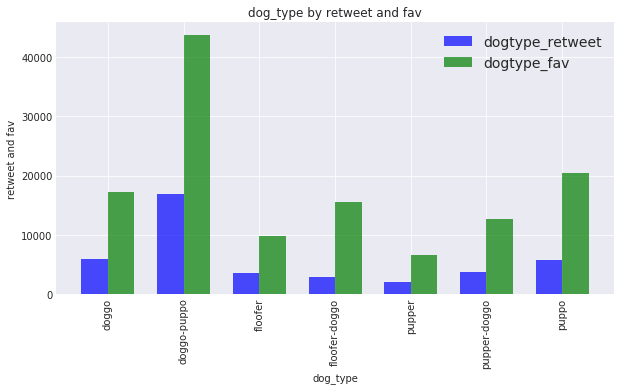

In [1387]:
dogtype_retweet = archive_master.groupby(['dog_type']).retweet_count.mean()
dogtype_fav = archive_master.groupby(['dog_type']).favorite_count.mean()

ind = np.arange(7) # the x locations for the groups
width = 0.35       # the width of the bars
f, ax = plt.subplots(figsize=(10,5))

# plot bars
dogtype_retweet_bars = plt.bar(ind, dogtype_retweet, width, color='b', alpha=.7, label='dogtype_retweet')
dogtype_fav_bars = plt.bar(ind + width, dogtype_fav, width, color='g', alpha=.7, label='dogtype_fav')

# title and labels
plt.ylabel('retweet and fav')
plt.xlabel('dog_type')
plt.title('dog_type by retweet and fav')

locations = ind + width / 2  # xtick locations
labels = ['doggo', 'doggo-puppo', 'floofer', 'floofer-doggo', 'pupper', 'pupper-doggo', 'puppo']  # xtick labels
plt.xticks(locations, labels)
plt.xticks(rotation=90)

# legend
plt.legend(fontsize = 14)
plt.savefig('dog_retweet_by_type.jpg')

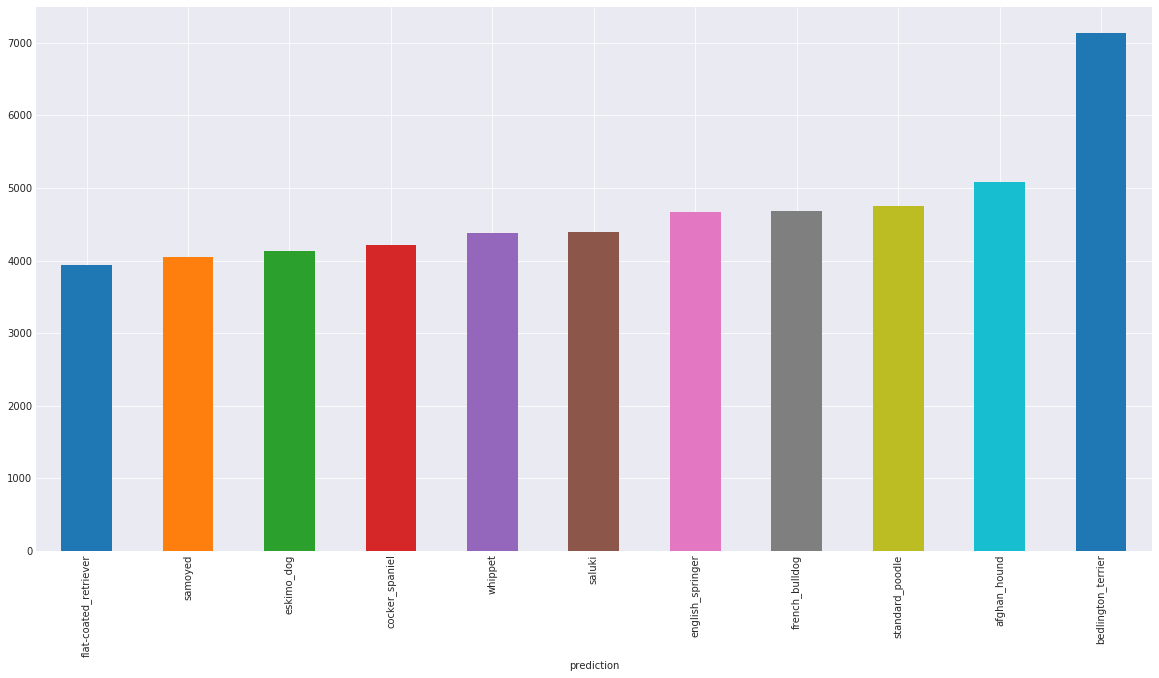

In [1395]:
archive_master.groupby(['prediction']).retweet_count.mean().sort_values(ascending=False)[10::-1].plot(kind='bar',figsize=(20, 10))
plt.savefig('prediction.jpg')

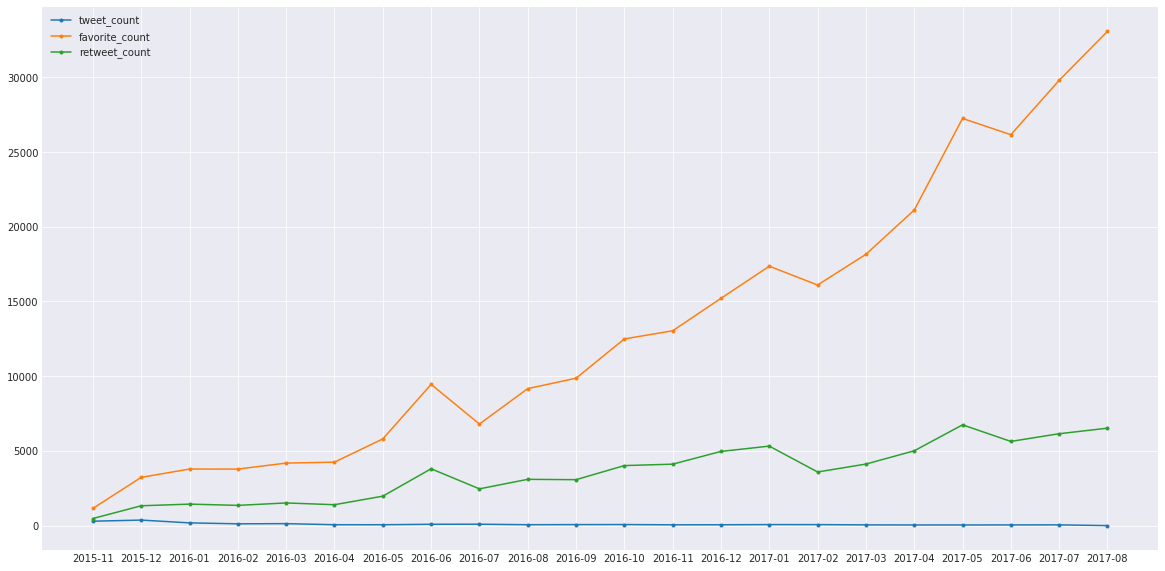

In [1389]:
tweet_count =archive_master.groupby(['month_year']).tweet_id.count()
retweet_count_mon= archive_master.groupby(['month_year']).retweet_count.mean()
fav_count_mon = archive_master_new.groupby(['month_year']).favorite_count.mean()
months=["2015-11","2015-12", "2016-01","2016-02","2016-03","2016-04","2016-05","2016-06","2016-07","2016-08",
        "2016-09","2016-10","2016-11","2016-12","2017-01","2017-02","2017-03","2017-04","2017-05","2017-06","2017-07","2017-08"]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(months, tweet_count, marker = '.')
ax.plot(months, fav_count_mon, marker = '.')
ax.plot(months, retweet_count_mon, marker = '.')
plt.setp(ax1.get_xticklabels(), rotation = 45)
plt.legend(('tweet_count','favorite_count','retweet_count'))
ax2.set(title = "Average retweet and Favorite compared to tweet numbers",
       xlabel = "month/year",
       ylabel = "Average Favorite/retweet count")
plt.show()
plt.savefig('tweet_acrosstime.jpg')

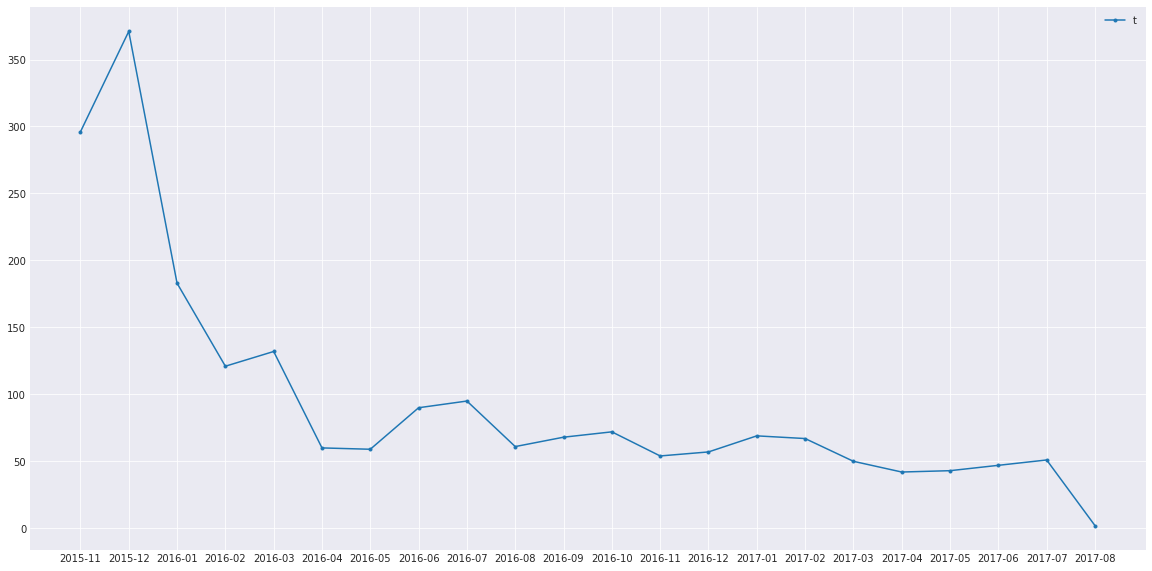

In [1390]:
tweet_count =archive_master.groupby(['month_year']).tweet_id.count()
months=["2015-11","2015-12", "2016-01","2016-02","2016-03","2016-04","2016-05","2016-06","2016-07","2016-08",
        "2016-09","2016-10","2016-11","2016-12","2017-01","2017-02","2017-03","2017-04","2017-05","2017-06","2017-07","2017-08"]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(months, tweet_count, marker = '.')
plt.setp(ax1.get_xticklabels(), rotation = 45)
plt.legend(('tweet_count'))
ax2.set(title = "tweet count per days",
       xlabel = "month/year",
       ylabel = "count")
plt.show()
plt.savefig('tweet_acrosstime2.jpg')


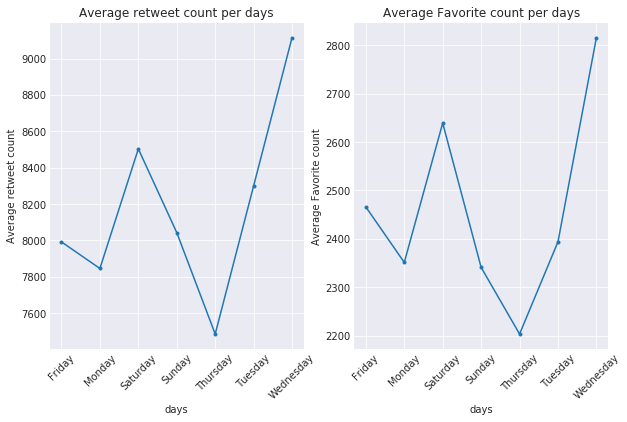

In [1391]:
retweet_count =archive_master.groupby(['day']).favorite_count.mean()
fav_count =archive_master.groupby(['day']).retweet_count.mean()
days = ["Friday","Monday","Saturday","Sunday","Thursday","Tuesday","Wednesday"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.plot(days, retweet_count, marker = '.')
ax1.set(title = "Average retweet count per days",
       xlabel = "days",
       ylabel = "Average retweet count")
ax2.plot(days, fav_count, marker = '.')
ax2.set(title = "Average Favorite count per days",
       xlabel = "days",
       ylabel = "Average Favorite count")


plt.setp(ax1.get_xticklabels(), rotation = 45)
plt.setp(ax2.get_xticklabels(), rotation = 45)

plt.show()
plt.savefig('tweet_acrossweek.jpg')

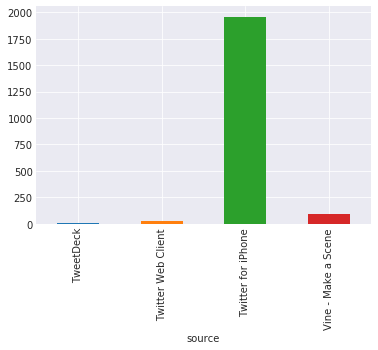

In [1392]:
archive_master.groupby(['source']).tweet_id.count().plot(kind='bar')
plt.savefig('tweet_persource.jpg')